### dropbox

In [1]:
# import dropbox
# from dropbox import DropboxOAuth2FlowNoRedirect

# APP_KEY = "qi3onmgezlr00yv"
# auth_flow = DropboxOAuth2FlowNoRedirect(APP_KEY, use_pkce=True, token_access_type='offline')

# authorize_url = auth_flow.start()
# print("1. Go to: " + authorize_url)
# print("2. Click \"Allow\" (you might have to log in first).")
# print("3. Copy the authorization code.")
# auth_code = input("Enter the authorization code here: ").strip()

# try:
#     oauth_result = auth_flow.finish(auth_code)
# except Exception as e:
#     print('Error: %s' % (e,))
#     exit(1)

# with dropbox.Dropbox(oauth2_refresh_token=oauth_result.refresh_token, app_key=APP_KEY) as dbx:
#     dbx.users_get_current_account()
#     print("Successfully set up client!")

In [3]:
# print(oauth_result.refresh_token)

b_N3-an_VvQAAAAAAAAAAc7kTAMBxeYC9GlsLpwgFrXX3kbZr2li3f3GfGx-iGnr


##

In [1]:
import dropbox
import os
from io import BytesIO
import time
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import re
import h5py

APP_KEY = 'qi3onmgezlr00yv'
REFRESH_TOKEN = 'b_N3-an_VvQAAAAAAAAAAc7kTAMBxeYC9GlsLpwgFrXX3kbZr2li3f3GfGx-iGnr'

In [2]:
def rss_coil_combine(image):
    squared_abs = np.abs(image)**2
    sum_of_squares = np.sum(squared_abs, axis=1)
    combined_images = np.sqrt(sum_of_squares)
    return combined_images

def Znormalization(image):
    mean = np.mean(image)
    std = np.std(image)
    if std == 0:
        tmp = image - mean/(std+1e-17)
    else:
        tmp = (image - mean) / (std)
    return tmp

def minmax_normalization(image):
    min_val = np.min(image)
    max_val = np.max(image)
    tmp = (image - min_val) / (max_val - min_val)
    return tmp

def ifft2c(k):
    x = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(k, (-2,-1)), norm='ortho'), (-2,-1))
    return x

def fft2c(img):
    k = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img, (-2,-1)), norm='ortho'), (-2,-1))
    return k

In [3]:
def crop(img, crop_size=320):
    height, width = img.shape[-2:]
    w_from = max(0, (width - crop_size) // 2)
    w_to = min(width, w_from + crop_size)
    h_from = (height - crop_size) // 2
    h_to = h_from + crop_size

    return img[:, h_from:h_to, w_from:w_to]

def padding(volume, size=320):
    slices, height, width = volume.shape
    pad_width = max(0, size - width) // 2 

    padded_volume = np.pad(
        volume,
        pad_width=((0, 0), (0, 0), (pad_width, pad_width)), 
        mode='edge'
    )
    return padded_volume

def correct_bias_field(input_np):
    input_sitk = sitk.GetImageFromArray(input_np)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    mask_sitk = sitk.OtsuThreshold(input_sitk, 0, 1, 200)
    corrected_image = corrector.Execute(input_sitk, mask_sitk)
    log_bias_field = corrector.GetLogBiasFieldAsImage(input_sitk)
    corrected_image_full_resolution = input_sitk / sitk.Exp(log_bias_field)
    corrected_np = sitk.GetArrayFromImage(corrected_image)
    corrected_np_full_resolution = sitk.GetArrayFromImage(corrected_image_full_resolution)
    return corrected_np_full_resolution


In [4]:
def dropbox_connect():
    dbx = dropbox.Dropbox(oauth2_refresh_token=REFRESH_TOKEN, app_key=APP_KEY)
    return dbx

def download_npy_file(dbx, dropbox_path, max_retries=3, delay=5):
    for attempt in range(max_retries):
        try:
            if attempt > 0:
                print(f"Downloading {dropbox_path}, attempt {attempt + 1}")
            _, response = dbx.files_download(dropbox_path)
            file_data = response.content
            npy_data = np.load(BytesIO(file_data))
            return npy_data
        except Exception as e:
            print(f"Error downloading {dropbox_path}: {e}")
            if attempt + 1 == max_retries:
                print(f"Max retries reached for {dropbox_path}")
                return None
            else:
                print(f"Retrying in {delay} seconds...")
                time.sleep(delay)

def load_npy_from_dropbox(dbx, folder_path, max_workers=12, data_type = 'volume'):
    data_dict = {}

    try:
        folder_metadata = dbx.files_list_folder(folder_path)
        futures = {}

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            for entry in folder_metadata.entries:
                if isinstance(entry, dropbox.files.FileMetadata) and entry.name.endswith('.npy'):
                    file_path = os.path.join(folder_path, entry.name)
                    numbers = re.findall(r'\d+', entry.name)
                    if data_type == 'volume':
                        subject_id = numbers[-1]
                    else:
                        subject_id = numbers[-3]
                    future = executor.submit(download_npy_file, dbx, file_path)
                    futures[future] = subject_id
                    
            for future in as_completed(futures):
                subject_id = futures[future]
                npy = future.result()
                if data_type == 'volume':
                    npy = rss_coil_combine(npy)
                data_dict[subject_id] = npy

    except Exception as e:
        print(f"Error accessing folder {folder_path}: {e}")

    return data_dict

In [5]:
def download_h5_file(dbx, dropbox_path, max_retries=3, delay=5):
    for attempt in range(max_retries):
        try:
            if attempt > 0:
                print(f"Downloading {dropbox_path}, attempt {attempt + 1}")
            _, response = dbx.files_download(dropbox_path)
            file_data = response.content
            
            h5_data =h5py.File(BytesIO(file_data))

            return h5_data

        except Exception as e:
            print(f"Error downloading {dropbox_path}: {e}")
            if attempt + 1 == max_retries:
                print(f"Max retries reached for {dropbox_path}")
                return None
            else:
                print(f"Retrying in {delay} seconds...")
                time.sleep(delay)

def load_h5_from_dropbox(dbx, folder_path, max_workers=12):
    data_dict = {}
    try:
        folder_metadata = dbx.files_list_folder(folder_path)
        futures = {}

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            for entry in folder_metadata.entries:
                if isinstance(entry, dropbox.files.FileMetadata) and entry.name.endswith('.h5'):
                    file_path = os.path.join(folder_path, entry.name)
                    numbers = re.findall(r'\d+', entry.name)
                    subject_id = numbers[-2]
                    future = executor.submit(download_h5_file, dbx, file_path)
                    futures[future] = subject_id

            for future in as_completed(futures):
                subject_id = futures[future]
                h5 = future.result()
                data_dict[subject_id] = h5

    except Exception as e:
        print(f"Error accessing folder {folder_path}: {e}")

    return data_dict

In [6]:
hf = download_h5_file(dropbox_connect(), '/fastMRI_data_h5_flair/file_brain_AXFLAIR_201_6003018.h5')
print(list(hf.keys()))
print(list(hf.attrs))
volume_kspace = hf['kspace'][()]
volume_img = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(volume_kspace), norm='ortho'))
print(volume_img.shape)

['ismrmrd_header', 'kspace', 'reconstruction_rss']
['acquisition', 'max', 'norm', 'patient_id']
(16, 16, 640, 320)


In [7]:
if __name__ == "__main__":
    dbx = dropbox_connect()
    dropbox_folder_path = '/Motion_data_whole_notrans_flair_0922'
    flair_motion = load_npy_from_dropbox(dbx, dropbox_folder_path)
    print(f"Loaded {len(flair_motion)} npy files.") #163

Loaded 163 npy files.


In [8]:
if __name__ == "__main__":
    dbx = dropbox_connect()
    dropbox_folder_path = '/fastMRI_data_h5_flair'
    flair_clear_h5 = load_h5_from_dropbox(dbx, dropbox_folder_path)
    print(f"Loaded {len(flair_clear_h5)} h5 files.") #163

Loaded 163 h5 files.


In [ ]:
output_folder = "/root/motioncorrection/flair/clear"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

flair_clear = {}
for subject_id, hf in flair_clear_h5.items():
    volume = hf['kspace'][()]
    volume = rss_coil_combine(ifft2c(volume))
    flair_clear[subject_id] = volume
print(len(flair_clear))

In [ ]:
if __name__ == "__main__":
    dbx = dropbox_connect()
    dropbox_folder_path = '/Motion_data_whole_notrans_t2_0922'
    t2_motion = load_npy_from_dropbox(dbx, dropbox_folder_path)
    print(f"Loaded {len(t2_motion)} npy files.") #165

In [ ]:
if __name__ == "__main__":
    dbx = dropbox_connect()
    dropbox_folder_path = '/Clear_data_notrans_t2_0922'
    t2_clear = load_npy_from_dropbox(dbx, dropbox_folder_path)
    print(f"Loaded {len(t2_clear)} npy files.") #165

In [14]:
if __name__ == "__main__":
    dbx = dropbox_connect()
    dropbox_folder_path = '/Motion_data_whole_notrans_t1post_0922'
    t1post_motion = load_npy_from_dropbox(dbx, dropbox_folder_path)
    print(f"Loaded {len(t1post_motion)} npy files.") #199

Loaded 199 npy files.


In [15]:
if __name__ == "__main__":
    dbx = dropbox_connect()
    dropbox_folder_path = '/Clear_data_notrans_t1post_0922'
    t1post_clear = load_npy_from_dropbox(dbx, dropbox_folder_path)
    print(f"Loaded {len(t1post_clear)} npy files.") #199

Loaded 199 npy files.


# Metric

In [16]:
from skimage.metrics import structural_similarity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import SimpleITK as sitk

### SSIM

In [28]:
"""
Reference : Similarity Metrics for MR Image-to-Image Translation
https://arxiv.org/pdf/2405.08431
"""

def calculate_ssim(clear_dict, motion_dict):
    results = []

    for key in clear_dict:
        if key in motion_dict:
            data_ref = clear_dict[key]
            data_img = motion_dict[key]
            crop_size = data_ref.shape[-1]
            data_ref = crop(data_ref, crop_size)
            data_img = crop(data_img, crop_size)

            for slice_idx in range(data_ref.shape[0]):
                ref_Z = Znormalization(data_ref[slice_idx])
                img_Z = Znormalization(data_img[slice_idx])
                ref_minmax = minmax_normalization(data_ref[slice_idx])
                img_minmax = minmax_normalization(data_img[slice_idx])
                data_range1 = max(ref_Z.max(), img_Z.max()) - min(ref_Z.min(), img_Z.min())
                data_range2 = max(ref_minmax.max(), img_minmax.max()) - min(ref_minmax.min(), img_minmax.min())
                ssim_value_Z = structural_similarity(img_Z, ref_Z, data_range=data_range1, gaussian_weights=True)
                ssim_value_minmax = structural_similarity(img_minmax, ref_minmax, data_range=data_range2, gaussian_weights=True)
                results.append({
                    'Subject ID': key,
                    'Slice Index': slice_idx,
                    'SSIM_Zscore': ssim_value_Z,
                    'SSIM_minmax': ssim_value_minmax
                    })

    df = pd.DataFrame(results)
    return df

In [29]:
df_flair = calculate_ssim(flair_clear, flair_motion)
df_t2 = calculate_ssim(t2_clear, t2_motion)
df_t1post = calculate_ssim(t1post_clear, t1post_motion)

In [ ]:
df_flair.to_csv('flair_SSIM.csv', index=False)
df_t2.to_csv('t2_SSIM.csv', index=False)
df_t1post.to_csv('t1post_SSIM.csv', index=False)

### motion

parameter 2d 기준
[translation y방향, translation x방향, 0, rotation yaw, 0,0]

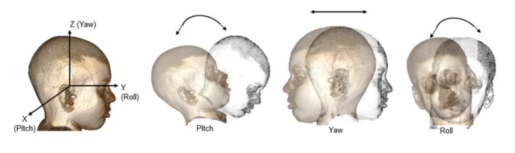

In [46]:
if __name__ == "__main__":
    dbx = dropbox_connect()
    dropbox_folder_path = '/MotionParam_apply_whole_notrans_flair_0922'
    flair_motion_param = load_npy_from_dropbox(dbx, dropbox_folder_path, data_type = 'param')
    print(f"Loaded {len(flair_clear_h5)} npy files.") #163
    dropbox_folder_path = '/MotionParam_apply_whole_notrans_t2_0922'
    t2_motion_param = load_npy_from_dropbox(dbx, dropbox_folder_path, data_type = 'param')
    print(f"Loaded {len(t2_motion_param)} npy files.") #165
    dropbox_folder_path = '/MotionParam_apply_whole_notrans_t1post_0922'
    t1_motion_param = load_npy_from_dropbox(dbx, dropbox_folder_path, data_type = 'param')
    print(f"Loaded {len(t1_motion_param)} npy files.") #199

Loaded 163 npy files.
Loaded 165 npy files.
Loaded 199 npy files.


In [48]:
def plot_motion_parameters(motion_parameters):
    translation = motion_parameters[:, :3]  
    rotation = motion_parameters[:, 3:]    
    time = np.arange(motion_parameters.shape[0])  
    translation_norm = np.linalg.norm(translation, axis=1)
    rotation_norm = np.linalg.norm(rotation, axis=1)

    plt.figure(figsize=(12, 16))

    plt.subplot(4, 1, 1)
    plt.plot(time, translation[:, 0], label='Translation X')
    plt.plot(time, translation[:, 1], label='Translation Y')
    plt.plot(time, translation[:, 2], label='Translation Z')
    plt.xlabel('Time (frames)')
    plt.ylabel('Translation (mm)')
    plt.title('Translation Parameters Over Time')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(time, rotation[:, 0], label='Rotation X (pitch)')
    plt.plot(time, rotation[:, 1], label='Rotation Y (yaw)')
    plt.plot(time, rotation[:, 2], label='Rotation Z (roll)')
    plt.xlabel('Time (frames)')
    plt.ylabel('Rotation (degrees or radians)')
    plt.title('Rotation Parameters Over Time')
    plt.legend()

    # Translation Norm Plot
    plt.subplot(4, 1, 3)
    plt.plot(time, translation_norm, label='Translation Norm', color='b')
    plt.xlabel('Time (frames)')
    plt.ylabel('Translation (mm)')
    plt.title('Translation Norm Over Time')
    plt.legend()

    # Rotation Norm Plot
    plt.subplot(4, 1, 4)
    plt.plot(time, rotation_norm, label='Rotation Norm', color='r')
    plt.xlabel('Time (frames)')
    plt.ylabel('Rotation (degrees or radians)')
    plt.title('Rotation Norm Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

def calculate_motion_parameters(param_dict):
    results = []
    for key in param_dict:
        motion_parameters = param_dict[key]
        translation = motion_parameters[:, :3]  
        rotation = motion_parameters[:, 3:]  
        displacement_rms = np.sqrt(np.mean(np.power(translation, 2)))
        rotation_rms = np.sqrt(np.mean(np.power(rotation, 2)))
        motion = np.sqrt(np.power(np.asarray(rotation_rms), 2) + np.power(np.asarray(displacement_rms), 2))
        results.append({
            'Subject ID': key,
            'displacement_rms' : displacement_rms,
            'rotation_rms': rotation_rms,
            'motion': motion
            })
        
    df = pd.DataFrame(results)
    return df

In [49]:
df_flair_param = calculate_motion_parameters(flair_motion_param)
df_t2_param = calculate_motion_parameters(t2_motion_param)
df_t1_param = calculate_motion_parameters(t1_motion_param)

df_flair_param.to_csv('flair_motion.csv', index=False)
df_t2_param.to_csv('t2_motion.csv', index=False)
df_t1_param.to_csv('t1_motion.csv', index=False)

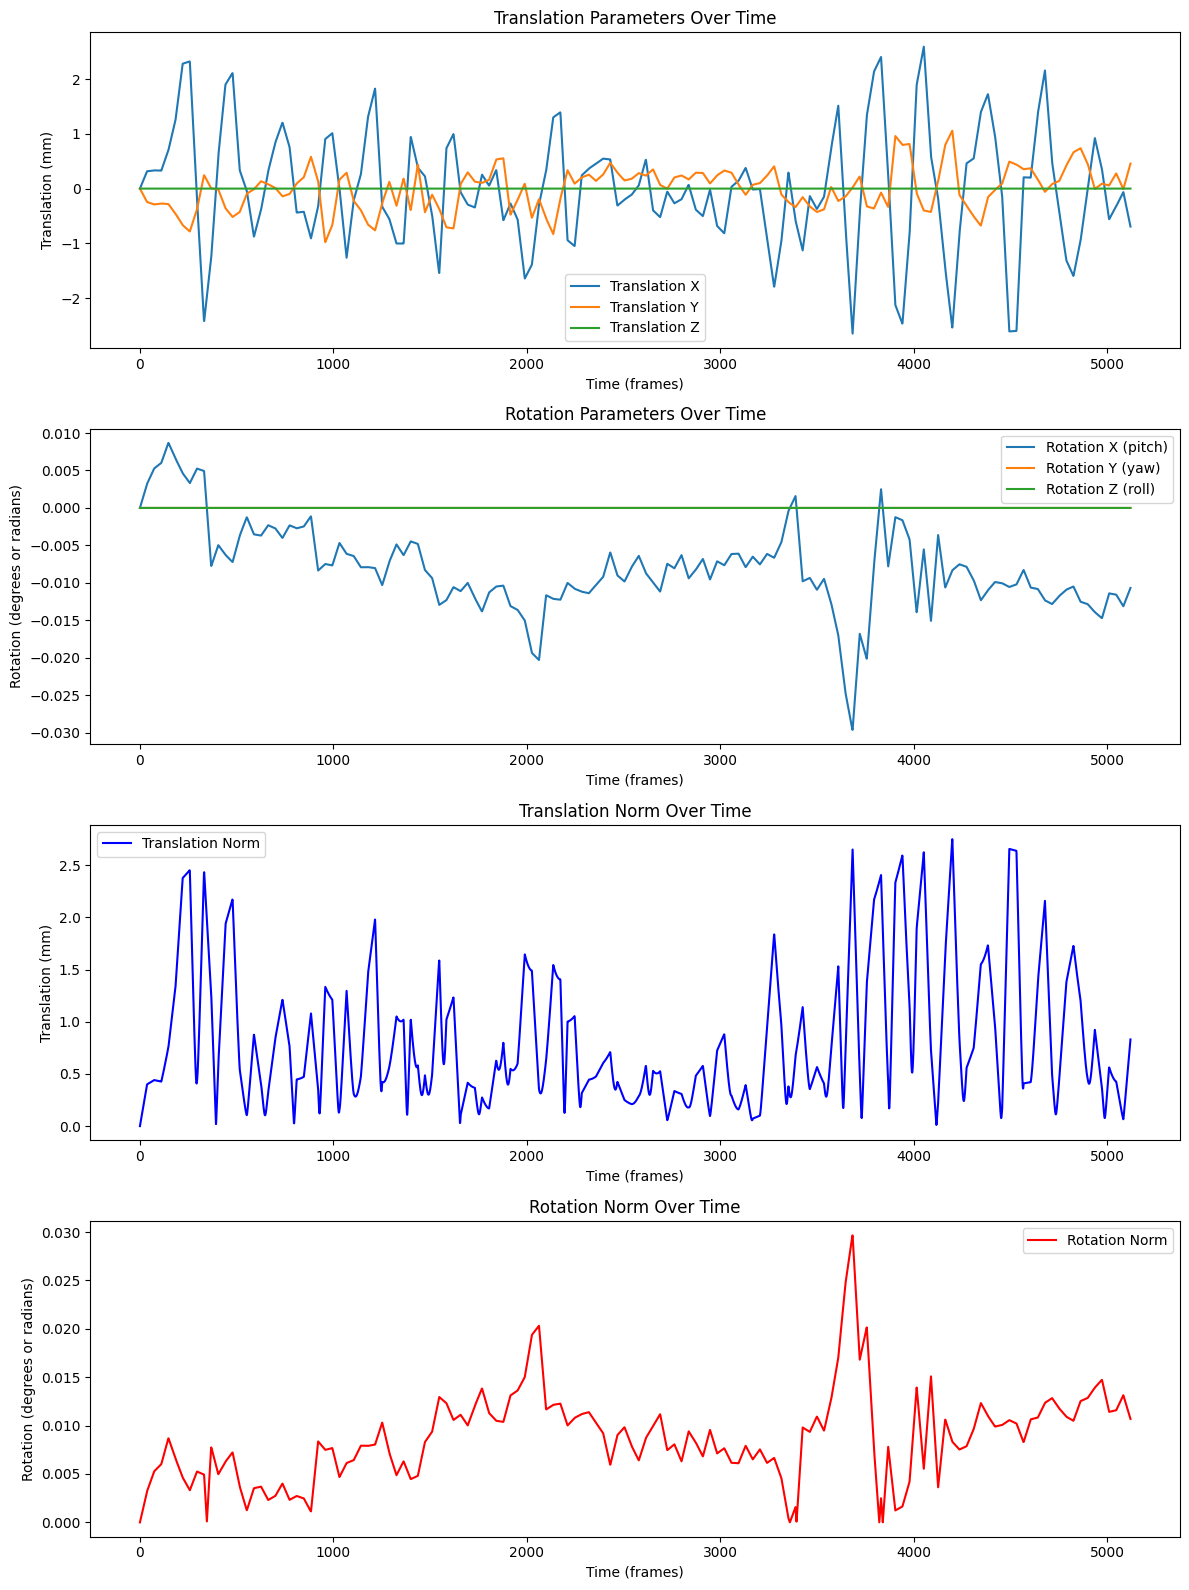

In [51]:
first_motion_param = list(flair_motion_param.values())[0]
plot_motion_parameters(first_motion_param)

## No reference metric

In [1]:
"""
Reference : Similarity Metrics for MR Image-to-Image Translation
https://arxiv.org/pdf/2405.08431
"""

from skimage.measure import blur_effect

def pearson_correlation(I, R):
    mean_I = np.mean(I)
    mean_R = np.mean(R)
    
    covariance = np.sum((I - mean_I) * (R - mean_R))
    standard_deviation_I = np.sqrt(np.sum((I - mean_I) ** 2))
    standard_deviation_R = np.sqrt(np.sum((R - mean_R) ** 2))
    
    pcc = covariance / (standard_deviation_I * standard_deviation_R)
    return pcc

def calculate_mlc(image):
    h, w = image.shape
    mlc_horizontal = np.mean([pearson_correlation(image[:, x], image[:, x+1]) for x in range(w-1)])
    mlc_vertical = np.mean([pearson_correlation(image[y, :], image[y+1, :]) for y in range(h-1)])
    return mlc_horizontal + mlc_vertical

def calculate_mslc(image):
    h, w = image.shape
    half_w, half_h = w // 2, h // 2
    mslc_horizontal = np.mean([pearson_correlation(image[:, x], image[:, x + half_w]) for x in range(w - half_w)])
    mslc_vertical = np.mean([pearson_correlation(image[y, :], image[y + half_h]) for y in range(h - half_h)])
    return mslc_horizontal + mslc_vertical

In [ ]:
def calculate_NR_metrics(dict):
    results = []
    for key in dict:
        img = dict[key]
        img = crop(img, img.shape[-1])
        for slice_idx in range(img.shape[0]):
            Z = Znormalization(img[slice_idx])
            minmax = minmax_normalization(img[slice_idx])
            BLUR_Z = blur_effect(Z)
            BLUR_minmax = blur_effect(minmax)
            MLC_Z = calculate_mlc(Z)
            MSLC_Z = calculate_mslc(Z)
            MLC_minmax = calculate_mlc(minmax)
            MSLC_minmax = calculate_mslc(minmax)

            results.append({
                'Subject ID': key,
                'Slice Index': slice_idx,
                'BLUR_Z': BLUR_Z,  
                'MLC_Z': MLC_Z,
                'MSLC_Z': MSLC_Z,
                'BLUR_minmax': BLUR_minmax,
                'MLC_minmax': MLC_minmax,
                'MSLC_minmax': MSLC_minmax
                })

    df = pd.DataFrame(results)
    return df

In [ ]:
flair_clear_NR_df = calculate_NR_metrics(flair_clear)
flair_motion_NR_df = calculate_NR_metrics(flair_motion)
t2_clear_NR_df = calculate_NR_metrics(t2_clear)
t2_motion_NR_df = calculate_NR_metrics(t2_motion)
t1post_clear_NR_df = calculate_NR_metrics(t1post_clear)
t1post_motion_NR_df = calculate_NR_metrics(t1post_motion)

In [ ]:
flair_clear_NR_df.to_csv('flair_clear_NR.csv', index=False)
flair_motion_NR_df.to_csv('flair_motion_NR.csv', index=False)
t2_clear_NR_df.to_csv('t2_clear_NR.csv', index=False)
t2_motion_NR_df.to_csv('t2_motion_NR.csv', index=False)
t1post_clear_NR_df.to_csv('t1post_clear_NR.csv', index=False)
t1post_motion_NR_df.to_csv('t1post_motion_NR.csv', index=False)

# Dataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import SimpleITK as sitk
import numpy as np
from ipywidgets import interact
from skimage.transform import rotate

In [ ]:
def plot_and_save_volume(mr_data, output_folder):
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for subject_id, volume in mr_data.items():
        num_slices = volume.shape[0]
        plt.figure(figsize=(20, 10))
        
        num_cols = min(4, num_slices)  
        num_rows = (num_slices + num_cols - 1) // num_cols  

        for i in range(num_slices):
            plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(volume[i], cmap='gray', origin='lower')
            plt.axis('off')

        plt.tight_layout()
        output_path = os.path.join(output_folder, f"{subject_id}.png")  
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()

In [15]:
def explore_3D_array_comparison(arr_before: np.ndarray, arr_after: np.ndarray, cmap: str = 'gray'):

  assert arr_after.shape == arr_before.shape

  def fn(SLICE):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10,10))

    ax1.set_title('Before', fontsize=15)
    ax1.imshow(arr_before[SLICE, :, :], cmap=cmap, origin='lower')

    ax2.set_title('After', fontsize=15)
    ax2.imshow(arr_after[SLICE, :, :], cmap=cmap, origin='lower')

    plt.tight_layout()

  interact(fn, SLICE=(0, arr_before.shape[0]-1))

In [ ]:
def process_dict(data_dict):
    for key, volume in data_dict.items():
        volume = correct_bias_field(volume)
        volume = crop(padding(volume, 396), 396)
        for i in range(volume.shape[0]): 
            volume[i, :, :] = Znormalization(volume[i, :, :])
        data_dict[key] = volume
    return data_dict

In [18]:
flair_motion = process_dict(flair_motion)
flair_clear = process_dict(flair_clear)
t2_motion = process_dict(t2_motion)
t2_clear = process_dict(t2_clear)
t1post_motion = process_dict(t1post_motion)
t1post_clear = process_dict(t1post_clear)

In [ ]:
plot_and_save_volume(flair_motion, '/root/motioncorrection/flair/motion')
plot_and_save_volume(flair_clear, '/root/motioncorrection/flair/clear')
plot_and_save_volume(t2_motion, '/root/motioncorrection/t2/motion')
plot_and_save_volume(t2_clear, '/root/motioncorrection/t2/clear')
plot_and_save_volume(t1post_motion, '/root/motioncorrection/t1post/motion')
plot_and_save_volume(t1post_clear, '/root/motioncorrection/t1post/clear')

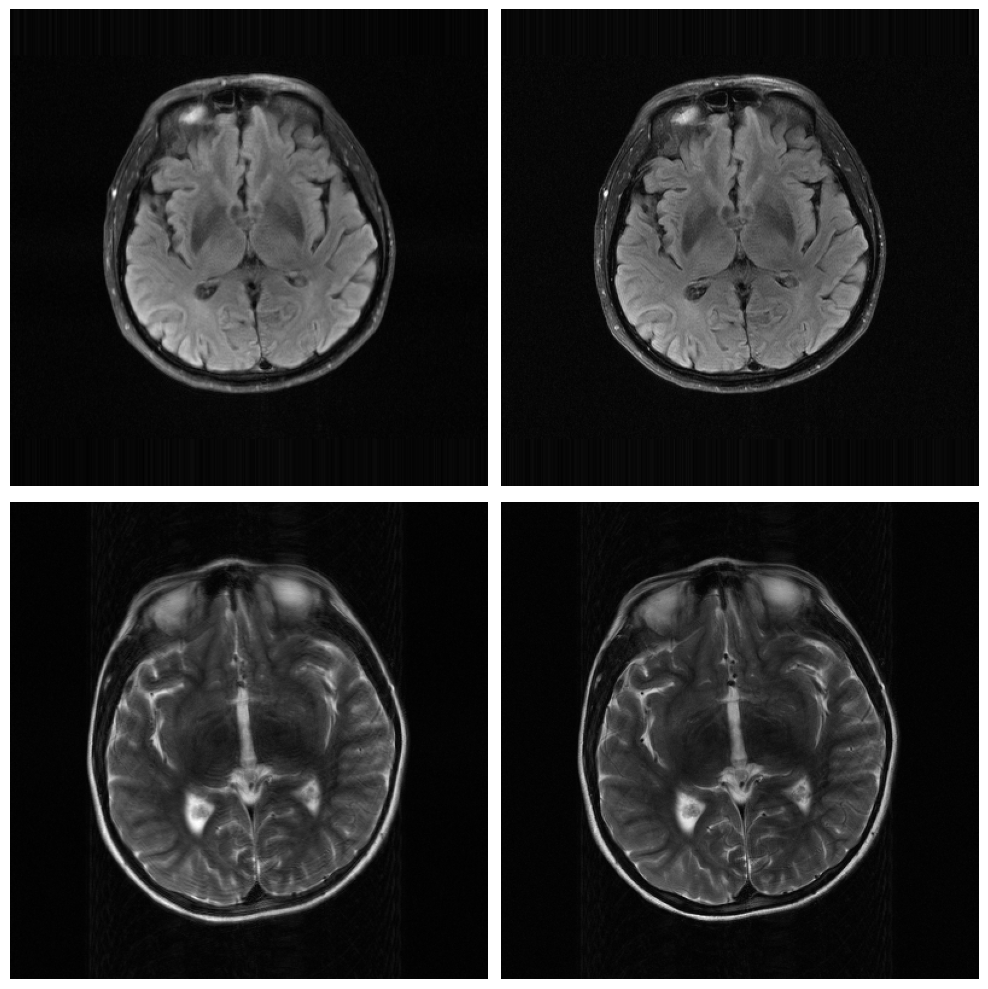

In [20]:
flair_motion['6002541'] = np.array([rotate(slice, 270, resize=False) for slice in flair_motion['6002541']])
flair_clear['6002541'] = np.array([rotate(slice, 270, resize=False) for slice in flair_clear['6002541']])
t2_motion['6002490'] = np.array([rotate(slice, 270, resize=False) for slice in t2_motion['6002490']])
t2_clear['6002490'] = np.array([rotate(slice, 270, resize=False) for slice in t2_clear['6002490']])

explore_3D_array_comparison(flair_motion['6002541'], flair_clear['6002541'])

In [ ]:
explore_3D_array_comparison(t2_motion['6002490'], t2_clear['6002490'])

In [ ]:
class MultiModalDataset(Dataset):
    def __init__(self, numpy_dicts, csv_paths, index):
        self.data = []
        for data_type, path in csv_paths.items():
            df = pd.read_csv(path)
            numpy_dict = numpy_dicts[data_type] 
            for _, row in df.iterrows():
                subject_id = row['Subject ID']
                slice_num = row['Slice Num']
                label = row[index]  # Label 열 이름이 올바른지 확인 필요
                image_array = numpy_dict[subject_id][slice_num, :, :]
                self.data.append((image_array, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_array, label = self.data[idx]
        image_tensor = torch.from_numpy(image_array).unsqueeze(0).float()
        label_tensor = torch.tensor(label, dtype=torch.float32)
        return image_tensor, label_tensor

In [ ]:
numpy_dicts = {
    'flair_clear': flair_clear,
    'flair_motion': flair_motion,
    't2_clear': t2_clear,
    't2_motion': t2_motion,
    't1post_clear': t1post_clear,
    't1post_motion': t1post_motion
}

csv_paths = {
    'flair_clear': 'flair_clear_NR.csv',
    'flair_motion': 'flair_motion_NR.csv',
    't2_clear': 't2_clear_NR.csv',
    't2_motion': 't2_motion_NR.csv',
    't1post_clear': 't1post_clear_NR.csv',
    't1post_motion': 't1post_motion_NR.csv'
}

dataset = MultiModalDataset(numpy_dicts, csv_paths, 'BLUR_Z')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for images, labels in dataloader:
    print("Image batch shape:", images.shape)
    print("Label batch:", labels)

# .

In [ ]:
import torch.nn as nn
import torch.optim as optim
